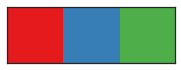

In [1]:
%matplotlib inline
from scipy.stats import linregress
from scipy.optimize import curve_fit
import seaborn as sns 
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
palette = sns.color_palette("Set1", 3)
sns.palplot(palette)
sns.set_palette(palette)
import scipy.io

In [2]:
fn = "plate_9_OD"
mat = scipy.io.loadmat('../data/idanf/%s.mat' % fn)

In [3]:
t = mat['tps']/3600.
t = t.reshape(max(t.shape))
y = mat['plate_mat']

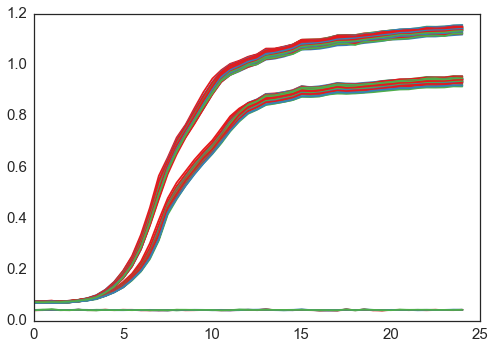

In [4]:
plot(np.transpose(t), np.transpose(y));

In [5]:
#control = mat['populations_OD'][0,0][3][0]
#assay = mat['populations_OD'][0,1][3][0]

## checkerboard
blank = np.arange(12)
assay = np.array([13,15,17,19,21,23,26,28,30,32,34,36,37,39,41,43,45,47,50,52,54,56,58,60,61,63,65,67,69,71,74,76,78,80,82,84,85,87,89,91,93,95])
control = np.array([14,16,18,20,22,24,25,27,29,31,33,35,38,40,42,44,46,48,49,51,53,55,57,59,62,64,66,68,70,72,73,75,77,79,81,83,86,88,90,92,94])

In [33]:
print control
print assay
t_control = t.copy()
y_control = y[control-1].T
t_assay = t.copy()
y_assay = y[assay-1].T

[14 16 18 20 22 24 25 27 29 31 33 35 38 40 42 44 46 48 49 51 53 55 57 59 62 64
 66 68 70 72 73 75 77 79 81 83 86 88 90 92 94]
[13 15 17 19 21 23 26 28 30 32 34 36 37 39 41 43 45 47 50 52 54 56 58 60 61 63
 65 67 69 71 74 76 78 80 82 84 85 87 89 91 93 95]


In [34]:
control_col = palette[0]
assay_col = palette[1]

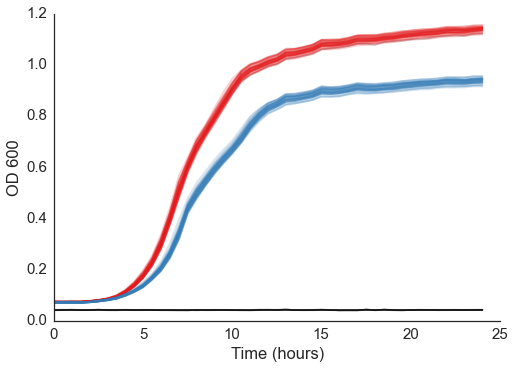

In [36]:
plot(t, np.transpose(y[blank-1]), color='k',  alpha=0.2);
plot(t_control, y_control, color=control_col, alpha=0.2);
plot(t_assay, y_assay, color=assay_col, alpha=0.2)
xlabel('Time (hours)')
ylabel('OD 600')
sns.despine()
savefig("ODvsTime_%s.png" % fn)

In [37]:
colors = {}
for i in blank: colors[i] = 'k'
for i in control: colors[i] = control_col
for i in assay: colors[i] = assay_col

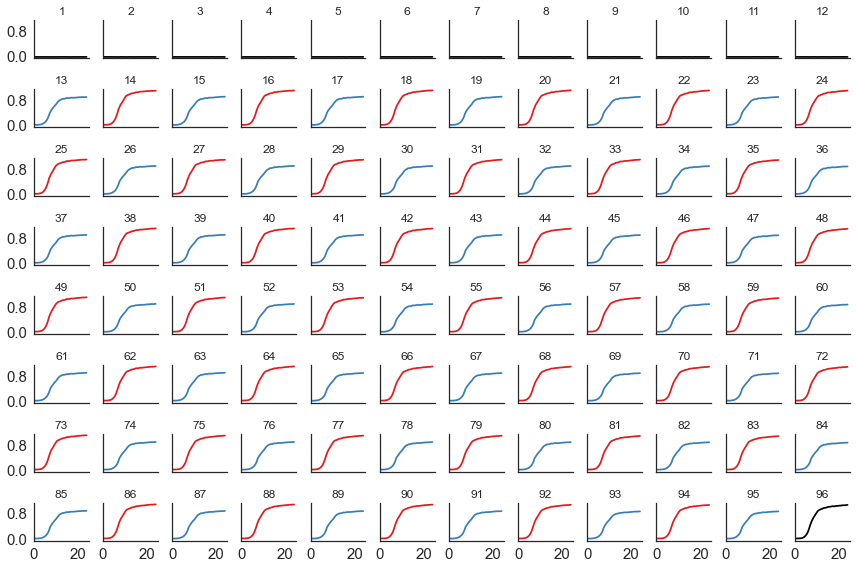

In [10]:
fig, ax = subplots(8,12,sharex=True, sharey=True, figsize=(12,8))
for i in range(8):
    for j in range(12):
        ax[i,j].plot(t, np.transpose(y[12*i + j]), color=colors.get(12*i + j+1, 'k'))
        ax[i,j].set_title(str(12*i+j+1), fontsize=12)
ax[0,0].set_xticks([0,20])
ax[0,0].set_yticks([0,0.8])
fig.tight_layout()
sns.despine()
fig.savefig("ODvsTime_96_%s.png" % fn)

## Exponential fitting

$$
\frac{dN}{dt} = r N \Rightarrow \\
N(t) = N_0 e^{rt} \Rightarrow \\
log(N_t) = log(N_0) + r t
$$

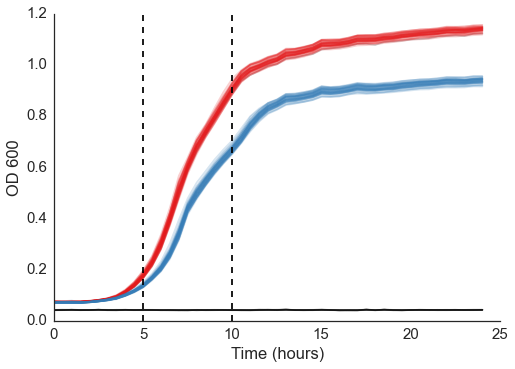

In [38]:
plot(t, np.transpose(y[blank-1]), color='k',  alpha=0.2);
plot(t_control, y_control, color=control_col, alpha=0.2);
plot(t_assay, y_assay, color=assay_col, alpha=0.2)
xlabel('Time (hours)')
ylabel('OD 600')
sns.despine()
axvline(x=5, color='k', ls='--')
axvline(x=10, color='k', ls='--')
savefig("ODvsTime_%s_start_stop.png" % fn)

In [39]:
exp_t = (t>=5) & (t<=8) 
t.shape, y_control.shape

((49L,), (49L, 41L))

In [41]:
slope, intercept, r_value, p_value, std_err = linregress(t_control[exp_t], np.log(y_control[exp_t,:]).mean(axis=1))
r_control, N0_control = slope, np.exp(intercept)
print "intercept",intercept, "slope", slope
print "r=%.3f, N0=%.3f" % (r_control, N0_control)
#plot(t_control[exp_t], intercept + slope * t_control[exp_t], 'k--')
#plot(t_control[exp_t], np.log(y_control[exp_t,:]).mean(axis=1), 'k.')

intercept -4.01064812243 slope 0.465875046805
r=0.466, N0=0.018


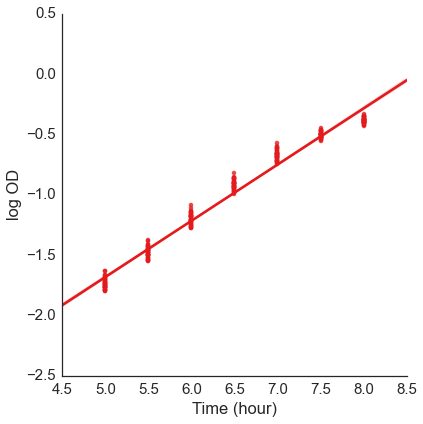

In [44]:
data = {('y%d'%i) :np.log(y_control[exp_t,i]) for i in range(y_control.shape[1])}
data.update({'t':t_control[exp_t]})
data = pd.DataFrame(data)
data = pd.melt(data, 't')
g = sns.lmplot('t', 'value', data, size=6, color=control_col)
ylabel("log OD")
xlabel("Time (hour)")
g.savefig("LogODvsTime_control.png")

-4.25451638369 0.450632059348
r=0.451, N0=0.014


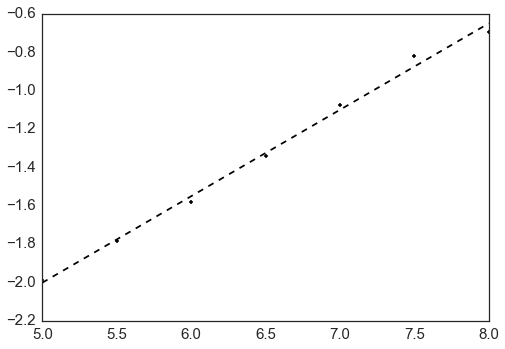

In [45]:
slope, intercept, r_value, p_value, std_err = linregress(t_assay[exp_t], np.log(y_assay[exp_t,:]).mean(axis=1))
r_assay, N0_assay = slope, np.exp(intercept)
print intercept, slope
print "r=%.3f, N0=%.3f" % (r_assay, N0_assay)
plot(t_assay[exp_t], intercept + slope * t_assay[exp_t], 'k--')
plot(t_assay[exp_t], np.log(y_assay[exp_t,:]).mean(axis=1), 'k.')

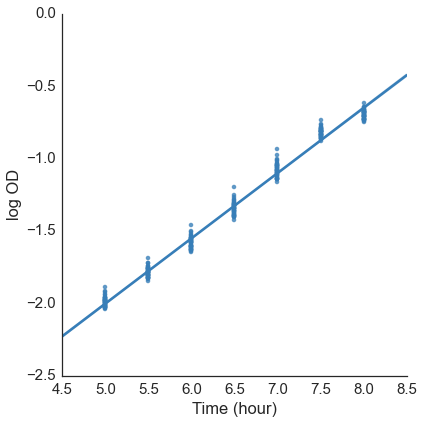

In [46]:
data = {('y%d'%i) :np.log(y_assay[exp_t,i]) for i in range(y_assay.shape[1])}
data.update({'t':t_assay[exp_t]})
data = pd.DataFrame(data)
data = pd.melt(data, 't')
g=sns.lmplot('t', 'value', data, size=6, color=assay_col)
ylabel("log OD")
xlabel("Time (hour)")
g.savefig("LogODvsTime_assay.png")

## Logistic fitting

$$
\frac{dN}{dt} = r N (1-N/K) \\
N(t) = \frac{K}{1 - \Big(1 - K/N_0 \Big) e^{-r t}}
$$

In [51]:
def logistic(t, *p):
    r, K, N0 = p
    return K  / ( 1 - (1 - K/N0) * np.exp(-r * t) )

In [52]:
(r_control,K_control,N0_control), pcov = curve_fit(logistic, np.repeat(t_control, y_control.shape[1]), y_control.flatten(), p0=(1,1,0))
perr = np.sqrt(np.diag(pcov))
print 'r',r_control,'K',K_control,'N0',N0_control
print 'errors',perr

r 0.579609666827 K 1.10893179814 N0 0.0147677241372
errors [ 0.003  0.001  0.   ]


In [53]:
(r_assay,K_assay,N0_assay), pcov = curve_fit(logistic, np.repeat(t_assay, y_assay.shape[1]), y_assay.flatten(), p0=(1,1,0))
perr = np.sqrt(np.diag(pcov))
print 'r',r_assay,'K',K_assay,'N0',N0_assay
print 'errors',perr

r 0.515517576331 K 0.925240009576 N0 0.0149797371887
errors [ 0.002  0.001  0.   ]


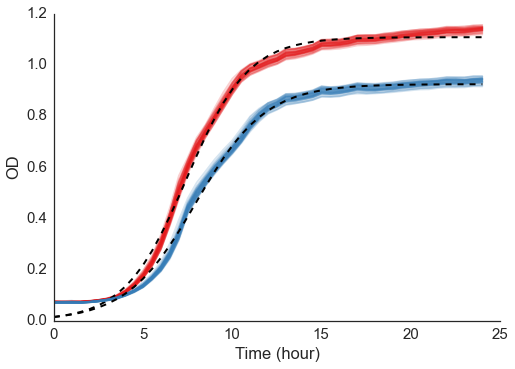

In [54]:
plot(t_control,  y_control, color=control_col, alpha=0.2)
plot(t_control, logistic(t_control, r_control, K_control, N0_control), 'k--', lw=2);
plot(t_assay,  y_assay, color=assay_col, alpha=0.2)
plot(t_assay, logistic(t_assay, r_assay, K_assay, N0_assay), 'k--', lw=2)
ylabel('OD')
xlabel('Time (hour)')
sns.despine()
savefig('ODvsTime_logistic.png')

## Richards

$$
\frac{dN}{dt} = r N (1-(N/K)^{\nu}) \\
N(t) = \frac{K}{\Big[1 - \Big(1 - \Big(\frac{K}{N_0}\Big)^{\nu}\Big) e^{-r \nu t}\Big]^{1/\nu}}
$$

In [73]:
def richards(t, *p):
    r, K, N0, nu = p
    return K / ((1 - (1 - (K/N0)**nu) * np.exp(-r * nu * t))**(1./nu))

In [74]:
(r_c,K_c,N0_c,nu_c), pcov = curve_fit(richards, np.repeat(t_control, y_control.shape[1]), y_control.flatten(), 
                                                     p0=[(1,1,0,1)])
perr = np.sqrt(np.diag(pcov))
print 'r',r_c,'K',K_c,'N0',N0_c,'nu',nu_c
print 'errors',perr

r 0.622667749337 K 1.11022760353 N0 0.0126499522506 nu 0.897711526577
errors [ 0.015  0.001  0.001  0.032]


In [76]:
(r_a,K_a,N0_a,nu_a), pcov = curve_fit(richards, np.repeat(t_assay, y_assay.shape[1]), y_assay.flatten(), 
                                                     p0=[(1,1,0,1)])
perr = np.sqrt(np.diag(pcov))
print 'r',r_a,'K',K_a,'N0',N0_a,'nu',nu_a
print 'errors',perr

r 0.434091885007 K 0.92182786527 N0 0.0208817974183 nu 1.32386485946
errors [ 0.007  0.001  0.001  0.037]


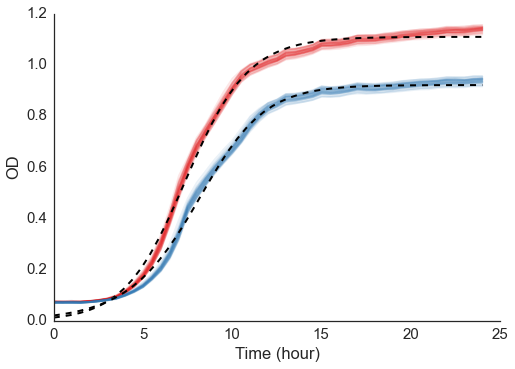

In [77]:
plot(t_control,  y_control, color=control_col, alpha=0.1)
t_ = np.linspace(t_control.min(),t_control.max())
plot(t_, [richards(t__, r_c,K_c,N0_c,nu_c) for t__ in t_], 'k--', lw=2);

plot(t_assay,  y_assay, color=assay_col, alpha=0.1)
t_ = np.linspace(t_assay.min(),t_assay.max())
plot(t_, [richards(t__, r_a,K_a,N0_a,nu_a) for t__ in t_], 'k--', lw=2);

ylabel('OD')
xlabel('Time (hour)')
sns.despine()
savefig('ODvsTime_Richards.png')

## Baranyi-Roberts

$$
\frac{dN}{dt} = r \alpha(t) N (1 - (N/K)^\nu) \\
A(t) = t + \frac{1}{v} \log{\Big( \frac{e^{-v t} + q_0}{1 + q_0} \Big)} \\
N(t) = \frac{K}{\Big( 1 + \Big( \Big(\frac{K}{N_0}\Big)^{\nu} - 1 \Big) e^{-r \nu A(t)} \Big)^{1/\nu}} \\
$$

In [78]:
def baranyi_roberts(t, K, y0, r, nu, q0, v):
    A = t + (1./v) * np.log((np.exp(-v*t) + q0)/(1 + q0))
    return K/(1 + (-1 + (K/y0)**nu) * np.exp(-r * nu * A))**(1./nu)

In [79]:
from lmfit import Model
def bic(model_fit):
    n = model_fit.ndata
    k = model_fit.nvarys    
    rss = np.float((model_fit.residual**2).sum())
    return n * np.log(rss / n) + np.log(n) * k

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [80]:
def fit_baranyi_roberts(t, y, well=None, ax=None, PLOT=True):
    models = []
    baranyi_roberts_model = Model(baranyi_roberts)
    params = baranyi_roberts_model.make_params(y0=y.min(), K=y.max(), r=1.0, nu=1.0, q0=0, v=1.0)
    params['y0'].set(min=1-10)
    params['K'].set(min=1-10)
    params['r'].set(min=1-10)
    params['nu'].set(min=1-10)
    params['q0'].set(min=1e-10, max=1)
    params['v'].set(min=1e-10)
    
    # full model
    result = baranyi_roberts_model.fit(y, t=t, params=params)
    models.append(result)
    
    # fix y0 and K to empirical data
    params['y0'].set(vary=False)
    params['K'].set(vary=False)
    result = baranyi_roberts_model.fit(data=y, t=t, params=params)
    models.append(result)
    
    # no lag
    params['q0'].set(value=1.0, vary=False)
    params['v'].set(vary=False)
    result = baranyi_roberts_model.fit(data=y, t=t, params=params)
    models.append(result)
    
    # logistic
    params['nu'].set(vary=False)
    result = baranyi_roberts_model.fit(data=y, t=t, params=params)
    models.append(result)
    
    # sort by increasing aic/bic
    models.sort(key=bic)

    # plot
    if PLOT:
        dy = y.max()/50
        dx = t.max()/25
        fig, ax = subplots(1, len(models), sharex=True, sharey=True, figsize=(16,6))
        for i,fit in enumerate(models):
            vals = fit.best_values
            fit.plot_fit(ax=ax[i], datafmt='.', fit_kws={'lw':4})
            ax[i].axhline(y=vals['y0'], color='k', ls='--')
            #ax[i].text(x=t.max() + dx, y=vals['y0'] + dy, s='y0')
            ax[i].axhline(y=vals['K'], color='k', ls='--')
            #ax[i].text(x=t.max() + dx, y=vals['K'] + dy, s='K')
            lam = np.log(1. + 1./vals['q0']) / vals['v']        
            ax[i].axvline(x=lam, color='k', ls='--')
            #ax[i].text(x=lam + dx, y=y.min() - 3*dy, s=r'$\lambda$')
            ax[i].set_title('Model: %s params, BIC: %d' % (fit.nvarys, bic(fit)))
            ax[i].get_legend().set_visible(False)            
            ax[i].set_xlim(0, 1.1 * t.max())
            ax[i].set_ylim(0, 1.1 * y.max())
            ax[i].set_xlabel('Time')
            ax[i].set_ylabel('')
        ax[0].set_ylabel('OD')
        sns.despine()
    return models, fig, ax

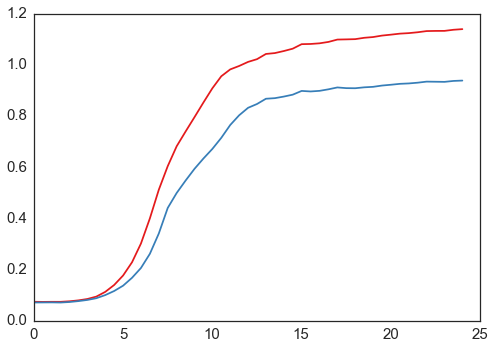

In [81]:
plot(t_control, y_control.mean(axis=1), color=control_col)
plot(t_assay, y_assay.mean(axis=1), color=assay_col)

[[Model]]
    Model(baranyi_roberts)
[[Fit Statistics]]
    # function evals   = 2369
    # data points      = 49
    # variables        = 6
    chi-square         = 0.007
    reduced chi-square = 0.000
[[Variables]]
    q0:   0.00042631 +/- 0.000956 (224.20%) (init= 1e-10)
    K:    1.11706351 +/- 0.003240 (0.29%) (init= 1.140454)
    r:    373.437866 +/- 1.25e+05 (33420.01%) (init= 1)
    v:    1.81941753 +/- 0.640979 (35.23%) (init= 1)
    y0:   0.07729649 +/- 0.005390 (6.97%) (init= 0.07392683)
    nu:   0.00117642 +/- 0.393425 (33442.38%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(r, nu)                     = -1.000 
    C(q0, v)                     = -0.977 
    C(r, v)                      = -0.722 
    C(v, nu)                     =  0.722 
    C(q0, r)                     =  0.567 
    C(q0, nu)                    = -0.567 
    C(q0, y0)                    = -0.563 
    C(v, y0)                     =  0.488 
    C(K, v)                      =  0.24

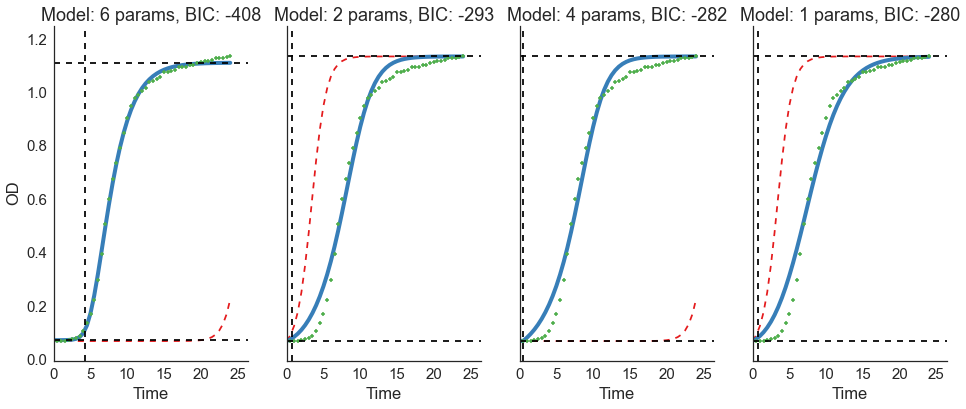

In [83]:
models, fig, ax = fit_baranyi_roberts(t_control, y_control.mean(axis=1), PLOT=True)
control_fit = models[0]
fig.savefig("baranyi_fit_control.png", figsize=(20,8))
print control_fit.fit_report()

[[Model]]
    Model(baranyi_roberts)
[[Fit Statistics]]
    # function evals   = 3336
    # data points      = 49
    # variables        = 6
    chi-square         = 0.005
    reduced chi-square = 0.000
[[Variables]]
    q0:   0.00163089 +/- 0.001859 (114.04%) (init= 1e-10)
    K:    0.92989451 +/- 0.002992 (0.32%) (init= 0.939319)
    r:    346.142467 +/- 1.31e+05 (37829.67%) (init= 1)
    v:    1.35173592 +/- 0.330719 (24.47%) (init= 1)
    y0:   0.07423241 +/- 0.004239 (5.71%) (init= 0.0714119)
    nu:   0.00118708 +/- 0.449016 (37825.05%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(r, nu)                     = -1.000 
    C(q0, v)                     = -0.925 
    C(r, v)                      = -0.717 
    C(v, nu)                     =  0.717 
    C(q0, y0)                    = -0.631 
    C(v, y0)                     =  0.518 
    C(K, v)                      =  0.454 
    C(q0, r)                     =  0.409 
    C(q0, nu)                    = -0.409

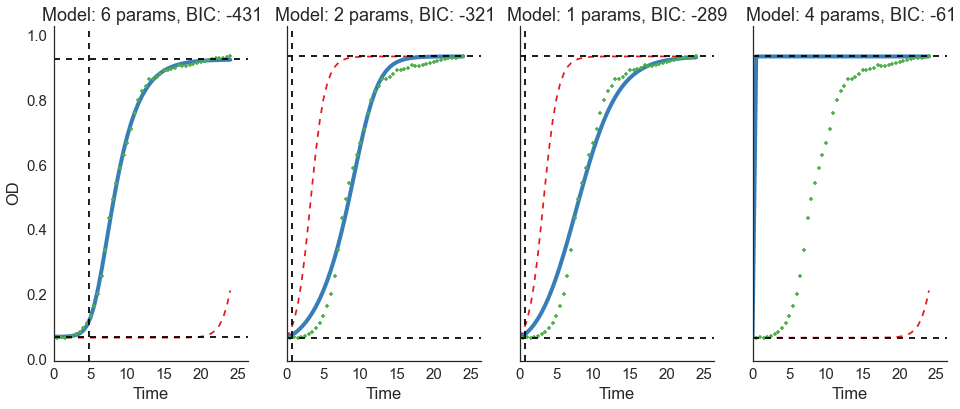

In [84]:
models, fig, ax = fit_baranyi_roberts(t_assay, y_assay.mean(axis=1), PLOT=True)
assay_fit = models[0]
fig.savefig("baranyi_fit_assay.png", figsize=(20,8))
print assay_fit.fit_report()

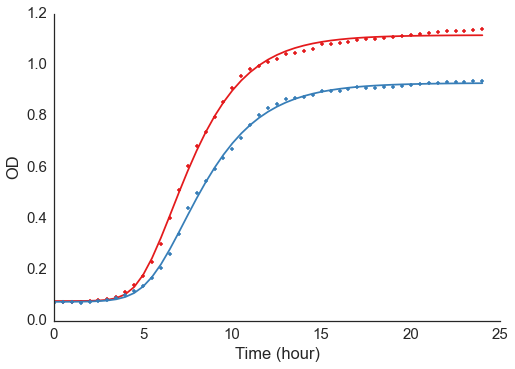

In [87]:
control_fit.plot_fit(data_kws={'marker':'.', 'color':control_col}, init_kws={'marker':'','ls':'', 'color':control_col})
assay_fit.plot_fit(data_kws={'marker':'.', 'color':assay_col}, init_kws={'marker':'','ls':'', 'color':assay_col})
lg = legend(loc='upper left')
lg.set_visible(False)
ylabel('OD')
xlabel('Time (hour)')
sns.despine()
savefig("plate_9_OD_fit.png", figsize=(24,16))

# Competition

$$
\frac{dy_i}{dt} = r_i y_i \alpha_i(t) \Big( 1 - \Big( \frac{\sum_j{y_j}}{K_i} \Big)^{\nu_i} \Big)
$$

In [88]:
import odespy

In [89]:
def get_params(model_fit):
    r = model_fit.best_values['r']
    K = model_fit.best_values['K']
    nu = model_fit.best_values['nu']
    q0 = model_fit.best_values['q0']
    v = model_fit.best_values['v']
    y0 = model_fit.best_values['y0']
    return y0,r,K,nu,q0,v

In [90]:
def alpha(t,q0,v):
    return q0 / (q0 + np.exp(-np.array(v)*t))

def dydt(y, t, r, K, nu, q0, v):
    alfa = alpha(t, q0, v)
    return r * y * alfa * (1 - (y.sum()/K)**nu)

In [91]:
y0_0,r_0,K_0,nu_0,q0_0,v_0 = get_params(control_fit)
y0_1,r_1,K_1,nu_1,q0_1,v_1 = get_params(assay_fit)

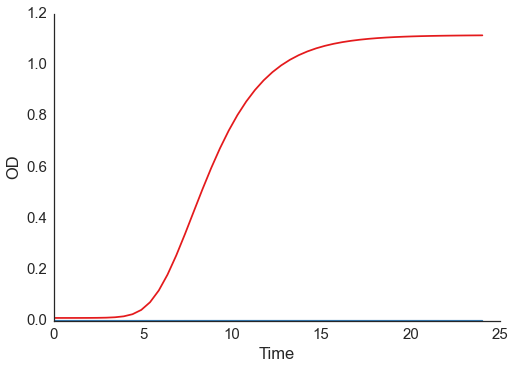

In [102]:
solver = odespy.RungeKutta4(lambda y,t: dydt(y, t, (r_0,r_1), (K_0,K_1), (nu_0,nu_1), (q0_0,q0_1), (v_0,v_1) ))
solver.set_initial_condition((y0_0,y0_1))
t = np.linspace(0, 24)
y,t = solver.solve(t)

plot(t,y[:,0], color=control_col)
plot(t,y[:,1], color=assay_col)
xlabel('Time')
ylabel('OD')
sns.despine()
savefig("ODvsTime_competition.png")

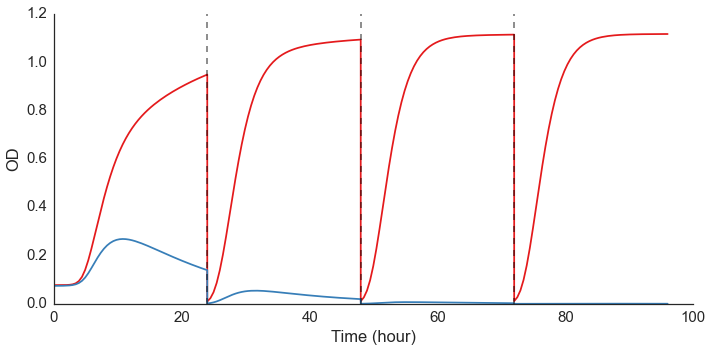

In [103]:
y0_0,r_0,K_0,nu_0,q0_0,v_0 = get_params(control_fit)
y0_1,r_1,K_1,nu_1,q0_1,v_1 = get_params(assay_fit)
t = np.array([0])
y = np.array([[y0_0,y0_1]])
cycle_len = 24
min_y = 1e-5
solver = odespy.RungeKutta4(lambda y,t: dydt(y, t, (r_0,r_1), (K_0,K_1), (nu_0,nu_1), (q0_0,q0_1), (v_0,v_1) ))

while y0_0 > min_y and y0_1 > min_y:
    solver.set_initial_condition((y0_0,y0_1))
    t_ = np.linspace(t.max(), t.max() + cycle_len) # TODO add lag!
    y_,t_ = solver.solve(t_)
    t = np.concatenate((t,t_))
    y = np.concatenate((y,y_))
    y0_0,y0_1 = y[-1,:]/100.

fig, ax = subplots(1,1,figsize=(10,5))
plot(t,y[:,0], color=control_col)
plot(t,y[:,1], color=assay_col)
ax.set_xlabel('Time (hour)')
ax.set_ylabel('OD')
sns.despine();
[axvline(x=x, color='k', ls='--', alpha=0.5) for x in np.arange(0, t.max(), cycle_len)];
fig.tight_layout()
fig.savefig("ODvsTime_evolution.png", figsize=(12,8))

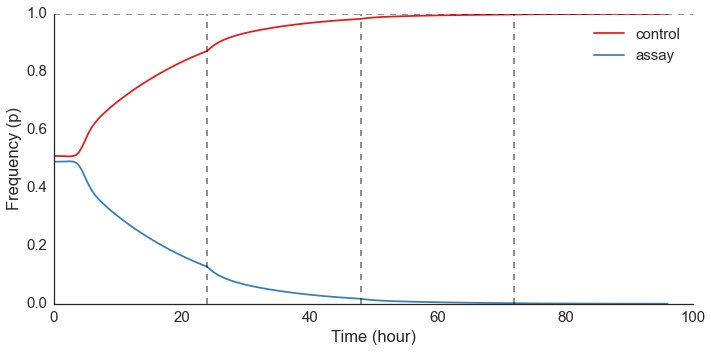

In [104]:
p = np.array([y[:,0]/y.sum(axis=1), y[:,1]/y.sum(axis=1)]).transpose()

fig, ax = subplots(1,1,figsize=(10,5))
ax.plot(t,p)
ax.axhline(y=1, ls='--', color='k', alpha=0.5)
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Frequency (p)')
ax.legend(labels=['control','assay'], loc='best') 
sns.despine();
[axvline(x=x, color='k', ls='--', alpha=0.5) for x in np.arange(0, t.max(), cycle_len)];
fig.tight_layout()
fig.savefig("pvsTime_evolution.png", figsize=(12,8))

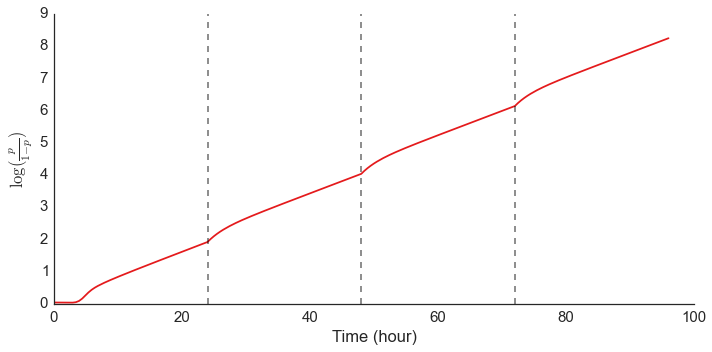

In [105]:
logpp = np.log(p[:,0]/p[:,1])

fig, ax = subplots(1,1,figsize=(10,5))
ax.plot(t, logpp, color=control_col)
ax.set_xlabel('Time (hour)')
ax.set_ylabel(r'$\log(\frac{p}{1-p})$')
sns.despine();
[axvline(x=x, color='k', ls='--', alpha=0.5) for x in np.arange(0, t.max(), cycle_len)];
fig.tight_layout()
fig.savefig("logp1-pvsTime_evolution.png", figsize=(12,8))

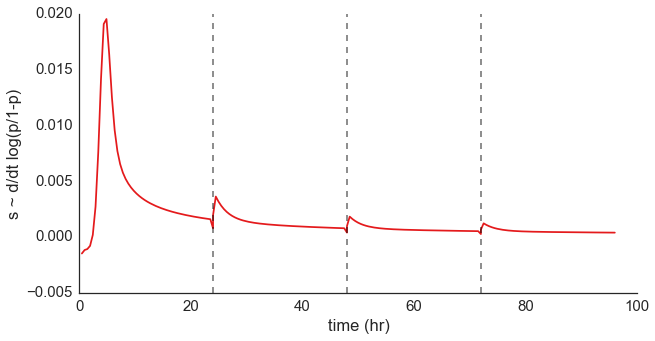

In [106]:
dlogppdt = np.gradient(logpp, t)

fig, ax = subplots(1,1,figsize=(10,5))
ax.plot(t,dlogppdt)
ax.set_xlabel('time (hr)')
ax.set_ylabel('s ~ d/dt log(p/1-p)')
sns.despine();
[axvline(x=x, color='k', ls='--', alpha=0.5) for x in np.arange(0, t.max(), cycle_len)];

In [107]:
def haldane(t,p0,s):
    return p0/(p0 + (1 - p0)*(1-s)**t)
haldane_model = Model(haldane)

{'p0': 0.5101105499417673, 's': 0.077388320684676853}


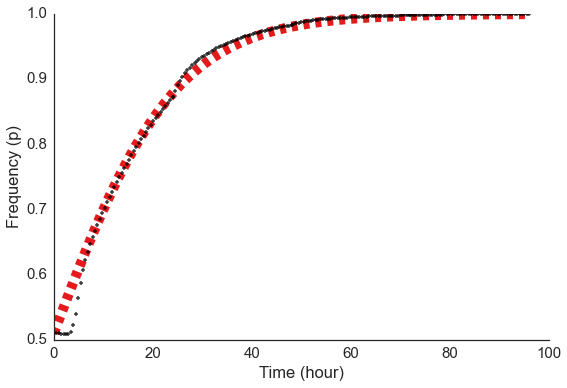

In [108]:
params = haldane_model.make_params(p0=p[0,0], s=0.01)
params['p0'].set(min=1e-10, max=1-1e-10, vary=False)
params['s'].set(min=1e-10, max=0.5)
model_fit = haldane_model.fit(p[:,0], t=t, params=params)
ax = model_fit.plot_fit(datafmt='.k', data_kws={"alpha":0.75}, fit_kws={"color":control_col, "ls":"--", "lw":10}, init_kws={"alpha":0})
ax.get_legend().set_visible(False)
#ax.axhline(y=model_fit.best_values['p0'], color='k', ls='--')
#legend(loc='lower right', fontsize=10)
ylabel('Frequency (p)')
xlabel('Time (hour)')
sns.despine()
tight_layout()
savefig("FreqvsTime_fit.png", figsize=(10,6))
print model_fit.best_values